# container experiment analysis
This script is design to create graphs and visuals based on experiments run with epmt in containers. Our goal is to view the difference in metrics between a simple script run in a normal environment, and run inside a container. To do this, we will be calling jobs with specific tags that state how they where run. We then will pull out their metrics and dsiplay them in a 3x3 grid histogram, overlaying the different scenarios.

Experiment run with fre version 2025.03

In [1]:
#get data to test on
import epmt_query as eq
import time
import sys
sys.path.insert(0,'/home/Avery.Kiihne/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Define the histogram function to use throughout script
def histo(jobs = [],factor = [], title = None, bins = None, scale = 'log', color = None):
    
    """
    Returns a bar graph of a specific metric from a set of jobs. Expects jobs with fmt='dict'.

    Parameters
    ----------
    
    jobs    : list, mandatory
              List of jobs in 'dict' format.
                 
    
    factor   : string, mandatory
             Mandatory. Variable plotted in histogram. must be one of the following:
             'exitcode','duration', 'rchar', 'syscr', 'syscw', 'wchar', 'cstime', 'cutime', 'majflt', 'cpu_time', 'minflt', 'rssmax', 'cmajflt',
             'cminflt', 'inblock', 'outblock', 'usertime', 'num_procs', 'processor', 'starttime', 'vol_ctxsw', 'guest_time', 'read_bytes', 'systemtime', 
             'time_oncpu', 'timeslices', 'invol_ctxsw', 'num_threads', 'write_bytes':, 'time_waiting', 'delayacct_blkio_time', 'cancelled_write_bytes'
             
    title    : string, optional
               Title at top of plot 
               
    bins  : int, optional
               Sets number of bins in histogram.
               Default is 50 bins
    
    scale    : string, optional*QH2S9T6XZgyZpd1
               Scaling factor for both x-axis and binning system. 
               By default, set to log scale. Only accepts 'log' or 'linear'.
               
    color    : string, optional
               Any color that matplotlib accepts.
               No input results in automatic color
    """
    #Plotting done with matplotlib
    import sys
    sys.path.insert(0,'/home/Ian.Laflotte/ians_py374/pip_experiment')
    import matplotlib.pyplot as plt
    import numpy as np
    
    #pull data from jobs
    data_list = []
    for job_instance in range(len(jobs)):
        if jobs[job_instance].get(factor) != None:   #prevents breakage if set is empty or doesn't exist
            data_list.append(jobs[job_instance][factor])
    #incase of a zero set
    if sum(data_list) == 0:
        return print('No non-zero data found in ',factor)
        
    #print(len(data_list))
    #make plot
    plt.figure()
    plt.style.use('default')
    
    #optional features
    #title of plot
    if title:
        plt.title(title)
    #set number of bins
    if bins:
        bins = bins
    else:
        bins = 50
    #bin check for zero, as it messes up np.log10()
    if min(data_list) == 0:
        bottom_bin = 0
    else:
        bottom_bin = np.log10(min(data_list))
    #set scaling factor
    if scale == 'log':
        plt.hist(data_list, bins = np.logspace(bottom_bin,np.log10(max(data_list)),bins), color = color)
        plt.xscale('log')
    if scale == 'linear':
        plt.hist(data_list, bins = np.linspace(min(data_list),max(data_list),bins), color = color)
        plt.xscale('linear')  

    #finish up
    plt.ylabel('Counts')
    plt.xlabel(factor)

In [5]:
#pull and sort jobs
#username = 'Avery.Kiihne'
control_jobs = eq.get_jobs(tags='group:control_6/23/25', fmt = 'dict') #eq.get_jobs(fltr=(eq.Job.user_id == username),fmt='dict')
container_jobs = eq.get_jobs(tags='group:container_6/23/25', fmt='dict')


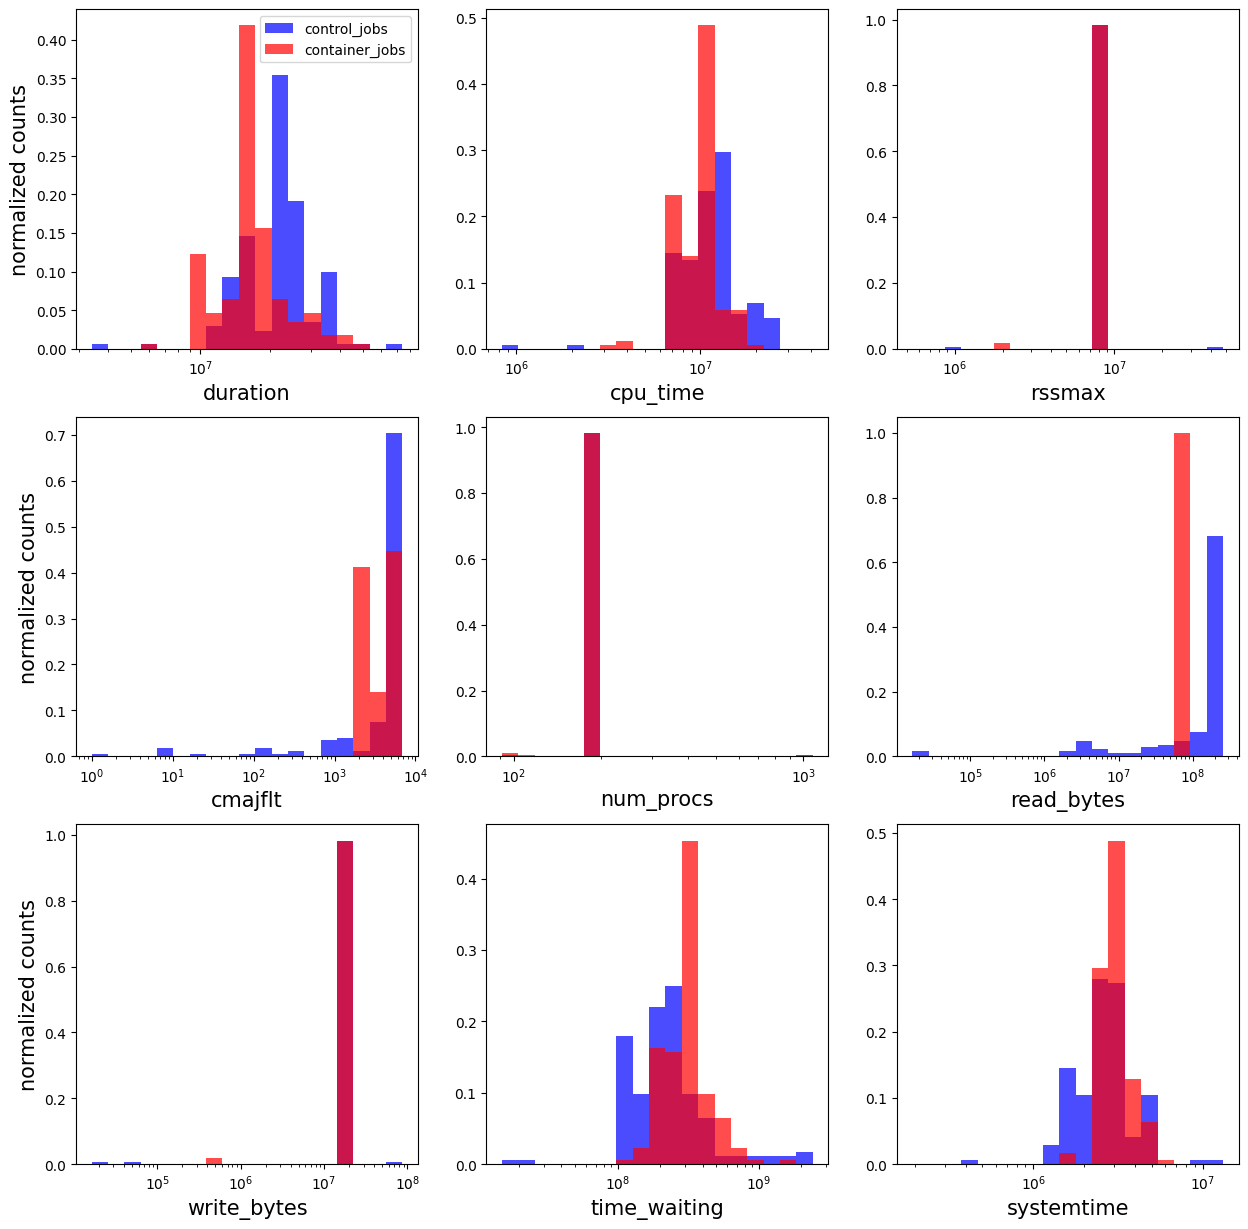

In [10]:
#subplot of every factor, with the spike data separated
factor_list = [ 'duration', 'cpu_time', 'rssmax', 'cmajflt', 'num_procs',  'read_bytes',  'write_bytes', 'time_waiting',  'systemtime']
data_list = {'red':{},'blue':{}}
binning = {}
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
ax =ax.ravel() 
for jobs in [control_jobs,container_jobs]:
    if jobs[0]['tags']['group'][0:9] == 'container':    #going to use color to also determine which set we are on
        color = 'red'
    else:
        color = 'blue'
    for ff in range(len(factor_list)):
        factor = factor_list[ff]
        data_list[color][factor] = []
        for job_instance in range(len(jobs)):
            if jobs[job_instance].get(factor) != None:   #prevents breakage if set is empty or doesn't exist
                data_list[color][factor].append(jobs[job_instance][factor])

#same loop, but for plotting
for jobs in [control_jobs,container_jobs]:
    if jobs[0]['tags']['group'][0:9] == 'container':    #going to use color to also determine which set we are on
        color = 'red'
    else:
        color = 'blue'
    for ff in range(len(factor_list)):
        factor = factor_list[ff]
        plt.style.use('default')
        bins = 20
        
        #make binning shared for all jobs
        if jobs[0]['tags']['group'][0:7] == 'control':
                    #bin check for zero, as it messes up np.log10()
            if min(data_list[color][factor]) == 0:
                bottom_bin = 0
            else:
                bottom_bin = np.log10(min(min(data_list['red'][factor]),min(data_list['blue'][factor])))
            binning[factor] = np.logspace(bottom_bin,np.log10(max(max(data_list['red'][factor]),max(data_list['blue'][factor]))),bins)
        
        #set scaling factor
        ax[ff].hist(data_list[color][factor], bins = binning[factor], color = color,density = False, weights = np.ones(len(data_list[color][factor]))/len(data_list[color][factor]),alpha = .7)
        ax[ff].set_xlabel(factor, fontsize = 15)
        ax[ff].set_xscale('log')
ax[0].set_ylabel('normalized counts', fontsize = 15)
ax[3].set_ylabel('normalized counts', fontsize = 15)
ax[6].set_ylabel('normalized counts', fontsize = 15)
ax[0].legend(['control_jobs','container_jobs'])
plt.savefig('analysis_plots/general_plots/container_histogram.pdf', bbox_inches='tight', format = 'pdf')


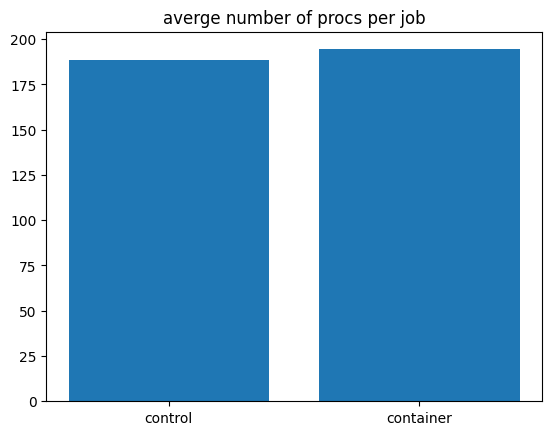

In [7]:
#generate plot comparing average number of procs per job
avg_procs = []
for experiment in [control_jobs,container_jobs]:
    total_procs = 0
    for job in experiment:
        total_procs += int(job['num_procs'])
    avg_procs.append(total_procs/len(experiment))
plt.bar(['control','container'],avg_procs)
plt.title('averge number of procs per job')
plt.savefig('analysis_plots/general_plots/container_avg_procs.pdf', bbox_inches='tight', format = 'pdf')

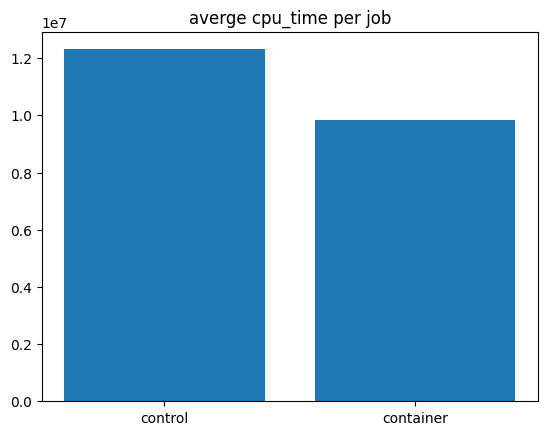

In [8]:
#generate plot comparing average cpu time per job
avg_cpu_time = []
for experiment in [control_jobs,container_jobs]:
    total_cpu_time = 0
    for job in experiment:
        total_cpu_time += int(job['cpu_time'])
    avg_cpu_time.append(total_cpu_time/len(experiment))
plt.bar(['control','container'],avg_cpu_time)
plt.title('averge cpu_time per job')
plt.savefig('analysis_plots/general_plots/container_avg_cpu.pdf', bbox_inches='tight', format = 'pdf')

In [2]:
#eq.get_jobs(jobs = ['46633193'], fmt = 'dict')

In [9]:
len(control_jobs)

172